In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

import warnings 
warnings.filterwarnings('ignore')

# Loading Dataset 

In [2]:
stopwords = pd.read_csv('stop_words.txt', index_col = False, sep = '\t', names = ['words'], encoding = 'utf-8')
stopwords.head()

,words
0,a
1,able
2,about
3,above
4,abst


In [3]:
SA = pd.read_csv('sentiment_analysis.csv', encoding = 'utf-8')
SA.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [4]:
USE = pd.read_csv('US_Elections_2020.csv', encoding = 'utf-8')
USE.head()

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN


# Part 1: Preprocessing Dataset

The requirements for cleaned dataset:

o All html tags and attributes (i.e., /<[^>]+>/) are removed.

o Html character codes (i.e., &...;) are replaced with an ASCII equivalent.

o All URLs are removed.

o All characters in the text are in lowercase.

o All stop words are removed. Be clear in what you consider as a stop word.

o If a tweet is empty after pre-processing, it should be preserved as such.

In [5]:
# delete useless info
del SA['ID']

# check missing values
SA.isna().sum()

text     0
label    0
dtype: int64

In [6]:
# check missing values
USE.isna().sum()

text                  0
sentiment             0
negative_reason    1288
dtype: int64

In [7]:
# fill in missing values
USE['negative_reason'] = USE['negative_reason'].fillna('None')

In [8]:
# Copy dataset for data cleaning
sentiment = SA.copy()
US_Elections = USE.copy()

In [9]:
import nltk
import re, string
import html
import unicodedata
from string import punctuation

def remove_html_tags(tweet):
    rules = re.compile('<.*?>')
    return re.sub(rules, '', tweet)

def replace_html_cc(tweet):
    text = html.unescape(tweet)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    return text.decode('UTF-8')

def remove_URL(tweet):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', tweet, flags=re.MULTILINE)
    return text

def replace_punctuation(tweet):
    rules = re.compile('[%s]' % re.escape(string.punctuation))
    return rules.sub('', tweet)

def extend_stop_words(wordlist):
    new_stop = ['rt', 'brt','http','https']
    stop_lst = wordlist.tolist()
    for word in new_stop:
        if word not in stop_lst:
            stop_lst.append(word)
    return stop_lst

stopwords_lst = extend_stop_words(stopwords['words'])

def remove_stopwords(tweet):
    wordlist = tweet.split()
    cleaned = [item for item in wordlist if item not in stopwords_lst]
    return " ".join(cleaned).strip()

def text_preprocess(tweet):
    tweet = tweet.lower()
    tweet = remove_html_tags(tweet)
    tweet = replace_html_cc(tweet)
    tweet = remove_URL(tweet)
    tweet = replace_punctuation(tweet)
    tweet = remove_stopwords(tweet)
    return tweet

In [10]:
sentiment['cleaned_text'] = sentiment['text'].apply(lambda x: text_preprocess(x))

In [11]:
US_Elections['cleaned_text'] = US_Elections['text'].apply(lambda x: text_preprocess(x))

In [12]:
sentiment

,text,label,cleaned_text
0,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins forward tab breeders crown super ...
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,mianusmanjaved congratulations pakistan no1tes...
2,"RT @PEPalerts: This September, @YESmag is taki...",1,pepalerts september yesmag maine mendozas surp...
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,davidgaibis newly painted walls custodial pain...
4,RT @CedricFeschotte: Excited to announce: as o...,1,cedricfeschotte excited july 2017 feschotte la...
...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,goddesseso cant watching hermm
550387,Poor old Tom Odell doesn't look like he would ...,0,poor tom odell doesnt wrong crowd
550388,#antsmasher I smashed 7 ants in this awesome ...,1,antsmasher smashed 7 ants awesome gamehjfjfi
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,lizhudston kymwyllie evasmiless meanbok linddy...


In [13]:
US_Elections

,text,sentiment,negative_reason,cleaned_text
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,brobreiner afraid nov dec jan bidenharris2020 ...
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,suec00k lord sumption launches recovery initia...
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,walidphares uber timing biden advisors pressur...
3,b'Every 107 seconds an American is dying from ...,1,None,bevery 107 seconds american dying trumpvirus n...
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,None,thewebbix democrats embrace diversityandinclus...
...,...,...,...,...
2547,"b'RT @BoycottUtah: It is Friday, October 30, 2...",1,None,boycottutah friday october 30 2020 citizen cal...
2548,b'@nowthisnews Delivered today in Montgomery C...,1,None,bnowthisnews delivered today montgomery county...
2549,b'@DonaldJTrumpJr DUHnnie Jr. lied on Fox when...,0,covid19,bdonaldjtrumpjr duhnnie jr lied fox number cov...
2550,b'RT @Pale_Ranger: Any ideas why @JoeBiden is ...,0,covid19,paleranger ideas joebiden wasting time minneso...


# Part2: EDA

Design a simple procedure that determines the political party (Republican Party, Democratic Party and Others) of a given tweet and apply this procedure to all the tweets in the 2020 US elections dataset. 


In [14]:
# search all the potentially relevant key words or hashtags for 2020 US elections dataset

def find_hashtag(tw):
    return re.findall(r"#(\w+)", tw)

In [15]:
sentiment['hashtag'] = sentiment['text'].apply(lambda x: find_hashtag(x))
US_Elections['hashtag'] = US_Elections['text'].apply(lambda x: find_hashtag(x))

In [16]:
sentiment

,text,label,cleaned_text,hashtag
0,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins forward tab breeders crown super ...,[]
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,mianusmanjaved congratulations pakistan no1tes...,"[No1TestTeam, JI_PakZindabadRallies]"
2,"RT @PEPalerts: This September, @YESmag is taki...",1,pepalerts september yesmag maine mendozas surp...,[]
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,davidgaibis newly painted walls custodial pain...,[EC_proud]
4,RT @CedricFeschotte: Excited to announce: as o...,1,cedricfeschotte excited july 2017 feschotte la...,[]
...,...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,goddesseso cant watching hermm,[]
550387,Poor old Tom Odell doesn't look like he would ...,0,poor tom odell doesnt wrong crowd,[]
550388,#antsmasher I smashed 7 ants in this awesome ...,1,antsmasher smashed 7 ants awesome gamehjfjfi,[antsmasher]
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,lizhudston kymwyllie evasmiless meanbok linddy...,[Friday]


In [17]:
def hashtag_count(hashtag_dict, hashtag_lst):
    for tag in hashtag_lst:
        tag = tag.lower()
        if tag not in hashtag_dict:
            hashtag_dict[tag] = 1
        else: 
            hashtag_dict[tag] += 1
    return hashtag_dict

Text(0.5, 1.0, 'Hashtags Distribution for Sentiment Analysis')

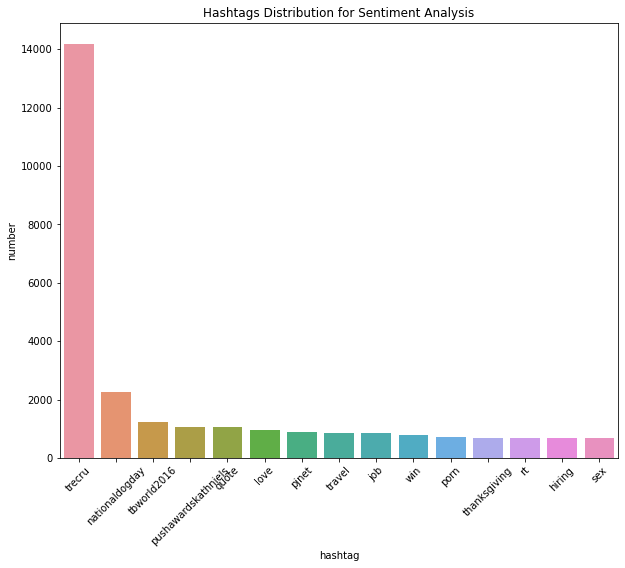

In [18]:
hashtag_dict = {}
count_dict_sa = sentiment['hashtag'].apply(lambda x: hashtag_count(hashtag_dict, x))
SA_HT = pd.DataFrame(list(count_dict_sa[0].items()),columns = ['hashtag','number'])
SA_HT.sort_values(by=['number'], ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(x = 'hashtag', y = 'number', data = SA_HT.iloc[0:15])
plt.xticks(rotation=45)
plt.title('Hashtags Distribution for Sentiment Analysis')

Text(0.5, 1.0, 'Hashtags Distribution for US Election')

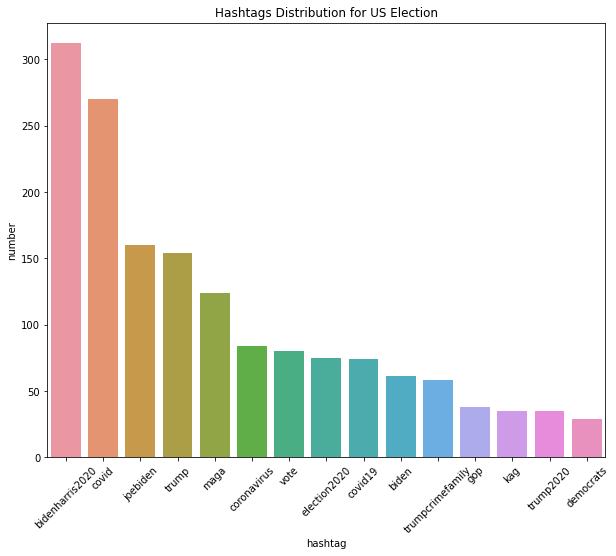

In [19]:
hashtag_dict = {}
count_dict_us = US_Elections['hashtag'].apply(lambda x: hashtag_count(hashtag_dict, x))
USE_HT = pd.DataFrame(list(count_dict_us[0].items()),columns = ['hashtag','number'])
USE_HT.sort_values(by=['number'], ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(x = 'hashtag', y = 'number', data = USE_HT.iloc[0:15])
plt.xticks(rotation=45)
plt.title('Hashtags Distribution for US Election')

In [20]:
Party_Word = {'DP': ['joe', 'biden', 'gop', 'democrat', 'democratic'], 'RP': ['donald', 'trump', 'tax', 'republican', 'republicanic']}

def distinguish_party(tweet, party_dict):
    In_RPWord = any([word in tweet for word in party_dict['RP']])
    In_DPWord = any([word in tweet for word in party_dict['DP']])
    
    if (not (In_RPWord or In_DPWord)) or (In_RPWord and In_DPWord):
        return 'Others'
    if In_RPWord and (not In_DPWord):
        return 'Republican Party'
    else:
        return 'Democratic Party'

Text(0.5, 1.0, 'Party Distribution in Sentiment Analysis Data')

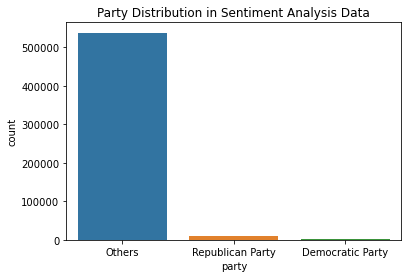

In [21]:
sentiment['party'] = sentiment['cleaned_text'].apply(lambda x: distinguish_party(x, Party_Word))

sns.countplot('party', data = sentiment)
plt.title('Party Distribution in Sentiment Analysis Data')

Text(0.5, 1.0, 'Party Distribution in US Elections 2020 Data')

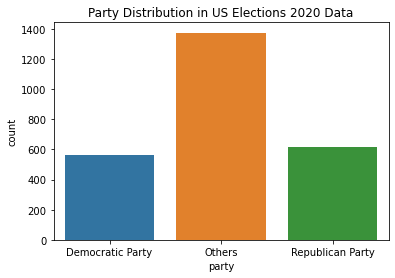

In [22]:
US_Elections['party'] = US_Elections['cleaned_text'].apply(lambda x: distinguish_party(x, Party_Word))

sns.countplot('party', data = US_Elections)
plt.title('Party Distribution in US Elections 2020 Data')

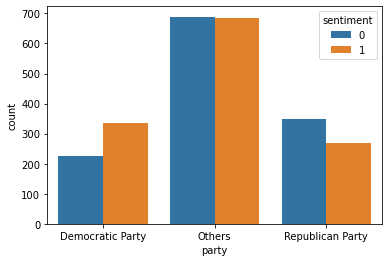

In [23]:
sns.countplot('party', hue='sentiment', data=US_Elections)

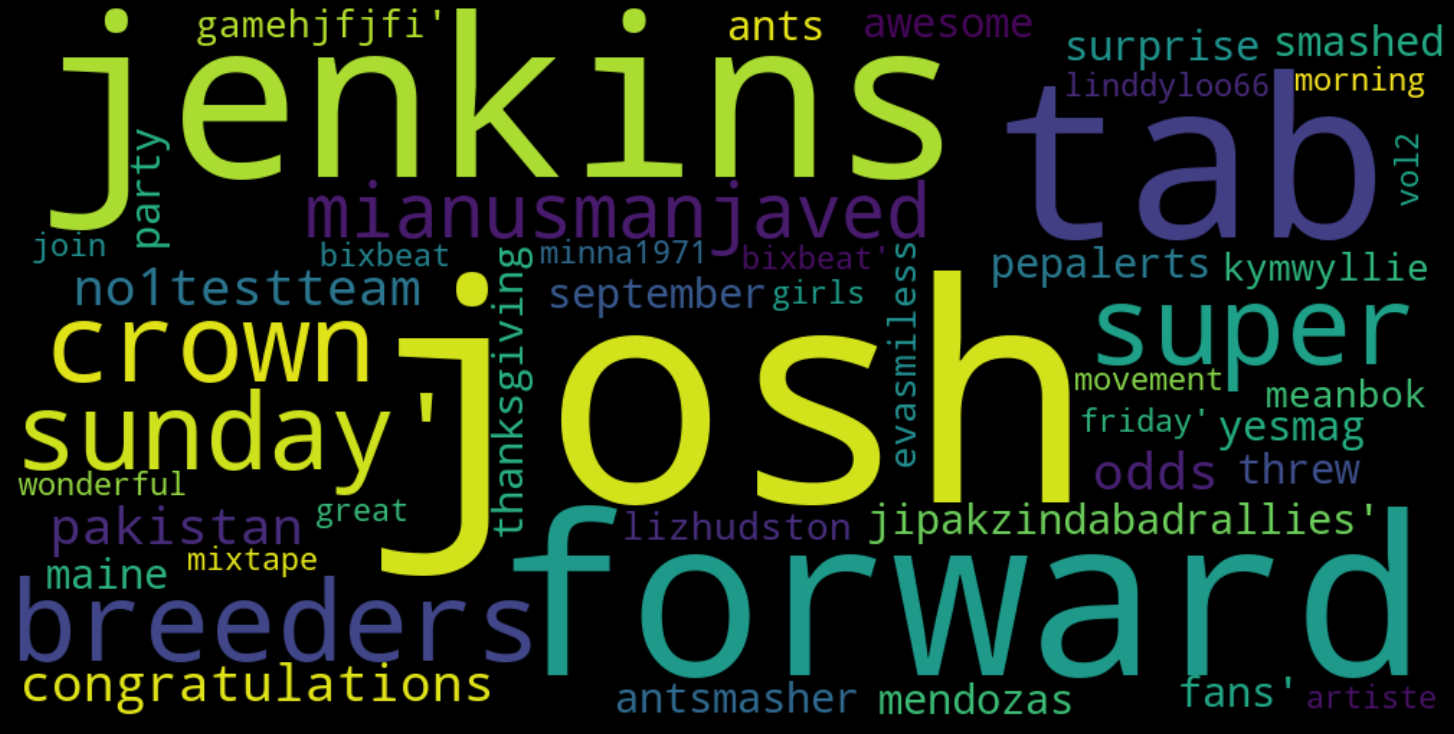

In [24]:
from wordcloud import WordCloud

word_SA = sentiment.cleaned_text.values
wordcloud = WordCloud(
    width = 1000,
    height = 500,
    background_color = 'black').generate(str(word_SA))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

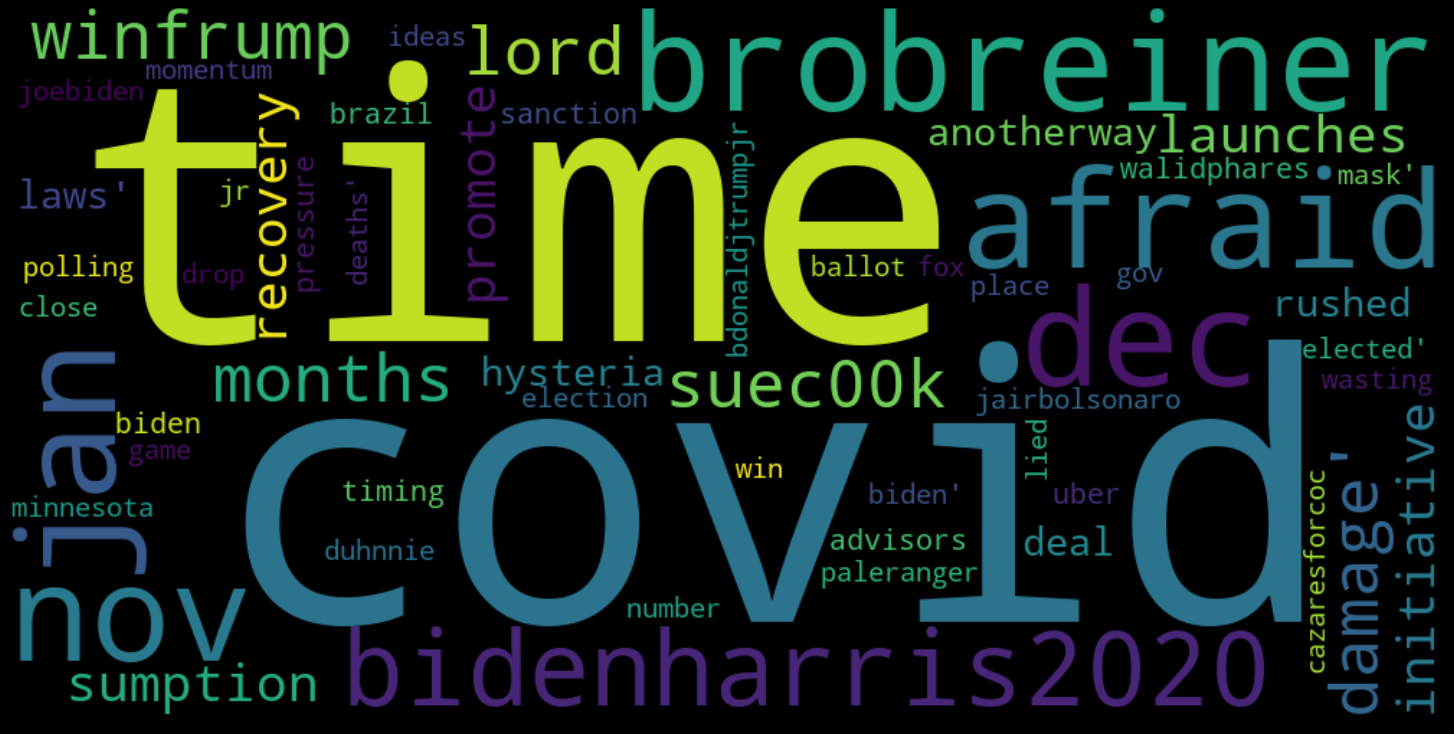

In [25]:
word_USE = US_Elections.cleaned_text.values
wordcloud = WordCloud(
    width = 1000,
    height = 500,
    background_color = 'black').generate(str(word_USE))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Part3: Model Preparation

In [26]:
def tokenize_stem(tweet):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(tweet)
    
    stemmer = nltk.stem.PorterStemmer()
    stemmed = [stemmer.stem(token) for token in tokens]

    return ' '.join(stemmed)

def lemma(tweet):
    stemmer = nltk.stem.WordNetLemmatizer()
    tokens = tweet.split()
    stemmed = [stemmer.lemmatize(token) for token in tokens]
    
    return " ".join(stemmed)

def create_bag(word, count_dict):
    if word not in count_dict:
        count_dict[word] = 1
    else:
        count_dict[word] += 1
    return count_dict

def word_bag(tweet):
    word_list = tweet.split()
    count_word = {}
    [create_dict(word, count_word) for word in word_list]
    return count_word

def bag_of_words(tweet):
    token = tokenize_stem(tweet)
    token = lemma(token)
    words = bag_of_words(token)
    return words

def remove_token_stopwords(tweet):
    token = tokenize_stem(tweet)
    token = lemma(token)
    token_nostop = remove_stopwords(token)
    return token_nostop

def generate_text_vector(df, column, category):
    text_list = df[column].tolist()
    text = ' '.join(text_list)
    text = text.split(' ')
    
    # create the transform
    if category == 'BOW':
        vectorizer = CountVectorizer(max_features=300)
    elif category == 'TFIDF':
        vectorizer = TfidfVectorizer(max_features=300)
    
    # tokenize and build vocab
    vectorizer.fit(text)
    return vectorizer

def vectorization(tweet, vectorizer):
    
    vector = vectorizer.transform([tweet])
    
    return vector.toarray()[0].tolist()
    

In [58]:
# tokenize the cleaned text 
sentiment['tokenized_text'] = sentiment['cleaned_text'].apply(lambda x: remove_token_stopwords(x))

sa_sample = sentiment.sample(n=10000)
# split the dataset
Xsa = sa_sample[['tokenized_text']]
ysa = sa_sample['label']
Xsa_train, Xsa_test, ysa_train, ysa_test = train_test_split(Xsa,ysa,test_size=0.3)

# generate the bag of word vector for each twitter in genertic dataset
vectorizer_bow = generate_text_vector(Xsa_train, 'tokenized_text','BOW')
Xsa_train['bow'] = Xsa_train['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_bow))
Xsa_test['bow'] = Xsa_test['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_bow))

Xsa_train_bow = Xsa_train['bow'].apply(pd.Series)
Xsa_test_bow = Xsa_test['bow'].apply(pd.Series)

# generate the TFIDF vector for each twitter in genertic dataset
vectorizer_tfidf = generate_text_vector(Xsa_train, 'tokenized_text','TFIDF')
Xsa_train['tfidf'] = Xsa_train['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_tfidf))
Xsa_test['tfidf'] = Xsa_test['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_tfidf))

Xsa_train_tfidf = Xsa_train['tfidf'].apply(pd.Series)
Xsa_test_tfidf = Xsa_test['tfidf'].apply(pd.Series)

Logistic Regression Model

In [59]:
# bag of words
LR_BOW = LogisticRegression()
LR_BOW.fit(Xsa_train_bow,ysa_train)
predictions = LR_BOW.predict(Xsa_test_bow)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

# tfidf
LR_TFIDF = LogisticRegression()
LR_TFIDF.fit(Xsa_train_tfidf,ysa_train)
predictions = LR_TFIDF.predict(Xsa_test_tfidf)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1011
           1       0.93      0.88      0.90      1989

    accuracy                           0.88      3000
   macro avg       0.86      0.87      0.86      3000
weighted avg       0.88      0.88      0.88      3000

[[ 872  139]
 [ 231 1758]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1011
           1       0.91      0.90      0.91      1989

    accuracy                           0.88      3000
   macro avg       0.86      0.87      0.86      3000
weighted avg       0.88      0.88      0.88      3000

[[ 842  169]
 [ 203 1786]]


KNN Model

In [60]:
# bag of words
KNN_BOW = KNeighborsClassifier(n_neighbors=3)
KNN_BOW.fit(Xsa_train_bow,ysa_train)
predictions = KNN_BOW.predict(Xsa_test_bow)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

# tfidf
KNN_TFIDF = KNeighborsClassifier(n_neighbors=3)
KNN_TFIDF.fit(Xsa_train_tfidf,ysa_train)
predictions = KNN_TFIDF.predict(Xsa_test_tfidf)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      1011
           1       0.92      0.84      0.88      1989

    accuracy                           0.85      3000
   macro avg       0.83      0.85      0.83      3000
weighted avg       0.86      0.85      0.85      3000

[[ 857  154]
 [ 309 1680]]
              precision    recall  f1-score   support

           0       0.67      0.81      0.73      1011
           1       0.89      0.79      0.84      1989

    accuracy                           0.80      3000
   macro avg       0.78      0.80      0.79      3000
weighted avg       0.82      0.80      0.80      3000

[[ 822  189]
 [ 409 1580]]


GaussianNB Model

In [61]:
# bag of words
NB_BOW = GaussianNB()
NB_BOW.fit(Xsa_train_bow,ysa_train)
predictions = NB_BOW.predict(Xsa_test_bow)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

# tfidf
NB_TFIDF = GaussianNB()
NB_TFIDF.fit(Xsa_train_tfidf,ysa_train)
predictions = NB_TFIDF.predict(Xsa_test_tfidf)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

              precision    recall  f1-score   support

           0       0.53      0.97      0.69      1011
           1       0.98      0.56      0.71      1989

    accuracy                           0.70      3000
   macro avg       0.75      0.77      0.70      3000
weighted avg       0.83      0.70      0.70      3000

[[ 983   28]
 [ 875 1114]]
              precision    recall  f1-score   support

           0       0.57      0.96      0.71      1011
           1       0.97      0.63      0.76      1989

    accuracy                           0.74      3000
   macro avg       0.77      0.79      0.74      3000
weighted avg       0.83      0.74      0.74      3000

[[ 971   40]
 [ 742 1247]]


SVM Model

In [62]:
# bag of words
SVM_BOW = svm.SVC()
SVM_BOW.fit(Xsa_train_bow,ysa_train)
predictions = SVM_BOW.predict(Xsa_test_bow)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

# tfidf
SVM_TFIDF = svm.SVC()
SVM_TFIDF.fit(Xsa_train_tfidf,ysa_train)
predictions = SVM_TFIDF.predict(Xsa_test_tfidf)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1011
           1       0.92      0.88      0.90      1989

    accuracy                           0.87      3000
   macro avg       0.85      0.87      0.86      3000
weighted avg       0.88      0.87      0.87      3000

[[ 864  147]
 [ 236 1753]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1011
           1       0.92      0.90      0.91      1989

    accuracy                           0.88      3000
   macro avg       0.86      0.87      0.86      3000
weighted avg       0.88      0.88      0.88      3000

[[ 847  164]
 [ 207 1782]]


Decision Tree Model

In [63]:
# bag of words
DF_BOW = DecisionTreeClassifier(criterion='entropy')
DF_BOW.fit(Xsa_train_bow,ysa_train)
predictions = DF_BOW.predict(Xsa_test_bow)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

# tfidf
DF_TFIDF = DecisionTreeClassifier(criterion='entropy')
DF_TFIDF.fit(Xsa_train_tfidf,ysa_train)
predictions = DF_TFIDF.predict(Xsa_test_tfidf)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1011
           1       0.92      0.87      0.89      1989

    accuracy                           0.86      3000
   macro avg       0.84      0.86      0.85      3000
weighted avg       0.87      0.86      0.86      3000

[[ 858  153]
 [ 265 1724]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1011
           1       0.92      0.87      0.89      1989

    accuracy                           0.86      3000
   macro avg       0.84      0.86      0.85      3000
weighted avg       0.87      0.86      0.86      3000

[[ 856  155]
 [ 259 1730]]


Random Forrest Model

In [64]:
# bag of words
RF_BOW = RandomForestClassifier(n_estimators=100, random_state=0)
RF_BOW.fit(Xsa_train_bow,ysa_train)
predictions = RF_BOW.predict(Xsa_test_bow)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

# tfidf
RF_TFIDF = RandomForestClassifier(n_estimators=100, random_state=0)
RF_TFIDF.fit(Xsa_train_tfidf,ysa_train)
predictions = RF_TFIDF.predict(Xsa_test_tfidf)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1011
           1       0.92      0.89      0.90      1989

    accuracy                           0.87      3000
   macro avg       0.85      0.86      0.86      3000
weighted avg       0.87      0.87      0.87      3000

[[ 848  163]
 [ 225 1764]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1011
           1       0.92      0.89      0.90      1989

    accuracy                           0.87      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.88      0.87      0.87      3000

[[ 847  164]
 [ 217 1772]]


XGBoost Model

In [65]:
# bag of words
GB_BOW = GradientBoostingClassifier(n_estimators=100, random_state=0)
GB_BOW.fit(Xsa_train_bow,ysa_train)
predictions = GB_BOW.predict(Xsa_test_bow)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

# tfidf
GB_TFIDF = GradientBoostingClassifier(n_estimators=100, random_state=0)
GB_TFIDF.fit(Xsa_train_tfidf,ysa_train)
predictions = GB_TFIDF.predict(Xsa_test_tfidf)

print(classification_report(ysa_test,predictions))
print(confusion_matrix(ysa_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.41      0.57      1011
           1       0.77      0.99      0.86      1989

    accuracy                           0.79      3000
   macro avg       0.86      0.70      0.72      3000
weighted avg       0.83      0.79      0.77      3000

[[ 414  597]
 [  21 1968]]
              precision    recall  f1-score   support

           0       0.95      0.41      0.57      1011
           1       0.77      0.99      0.86      1989

    accuracy                           0.79      3000
   macro avg       0.86      0.70      0.72      3000
weighted avg       0.83      0.79      0.76      3000

[[ 410  601]
 [  23 1966]]


# Model implementation and tuning

1. Train models on the training data and apply the model to the test data to obtain an accuracy value. 
2. Evaluate the same model with best performance on the 2020 US elections data. 
3. Choose the model that has the best performance and visualize sentiment prediction results and the true sentiment for each of the two  parties/candidates. 
4. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

In [66]:
# tokenize the cleaned text 
US_Elections['tokenized_text'] = US_Elections['cleaned_text'].apply(lambda x: remove_token_stopwords(x))

US_pred = US_Elections.copy()

# Choose the best model to apply on prediction
US_pred['bow'] = US_pred['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_bow))
US_bow = US_pred['bow'].apply(pd.Series)
True_sentiment = US_pred['sentiment'].apply(pd.Series) 

From above models, the best one is logistic regression with bag of words vertorization. Then I applied the same model on election data. 

In [67]:
predictions = LR_BOW.predict(US_bow)
US_pred['prediction'] = predictions

print(classification_report(True_sentiment,predictions))
print(confusion_matrix(True_sentiment,predictions))

              precision    recall  f1-score   support

           0       0.55      0.83      0.67      1264
           1       0.68      0.34      0.46      1288

    accuracy                           0.59      2552
   macro avg       0.62      0.59      0.56      2552
weighted avg       0.62      0.59      0.56      2552

[[1054  210]
 [ 846  442]]


Text(0.5, 1.0, 'True Sentiment based on Parties')

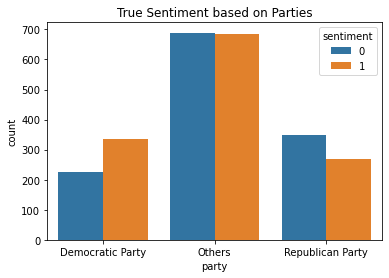

In [68]:
sns.countplot('party', hue='sentiment', data=US_pred)
plt.title('True Sentiment based on Parties')

Text(0.5, 1.0, 'Predicted Sentiment based on Parties')

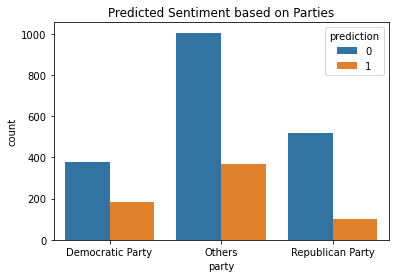

In [69]:
sns.countplot('party', hue='prediction', data=US_pred)
plt.title('Predicted Sentiment based on Parties')

When I applied the best model trained from previous dataset on US elections 2020 dataset, I found the prediction outcome is not well as the accuracy is 0.59, which is not well matched the sentiment labelled in the 2020 US elections data. From the visualizations, there is a big difference between the distribution true sentiment based on parties and the distribution of predict sentiment based on parties. Among them, those predicted to be positive are significantly reduced and negative are significantly increased. 

The reason for this situation may be that the information in the sentiment database is more general, while the election data is more specific, and the information is concentrated on the election. Therefore, I might conclude that apply the best model trained from the sentiment analysis data on election data is not suitable. Therefore, it is difficult to predict the distribution of sentiment among parties by looking at the content of tweets with this model. And I try to repeat the train and test procedrue on the US Elections 2020 Data.

In [70]:
# split the dataset
Xus = US_Elections[['tokenized_text', 'sentiment']]
yus = US_Elections[['sentiment', 'negative_reason', 'party']]
Xus_train, Xus_test, yus_train_SN, yus_test_SN = train_test_split(Xus,yus,test_size=0.3)
yus_train = yus_train_SN['sentiment']
yus_test = yus_test_SN['sentiment']

# generate the bag of word vector for each twitter in genertic dataset
vectorizer_bow = generate_text_vector(Xus_train, 'tokenized_text','BOW')
Xus_train['bow'] = Xus_train['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_bow))
Xus_test['bow'] = Xus_test['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_bow))

Xus_train_bow = Xus_train['bow'].apply(pd.Series)
Xus_test_bow = Xus_test['bow'].apply(pd.Series)

# generate the TFIDF vector for each twitter in genertic dataset
vectorizer_tfidf = generate_text_vector(Xus_train, 'tokenized_text','TFIDF')
Xus_train['tfidf'] = Xus_train['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_tfidf))
Xus_test['tfidf'] = Xus_test['tokenized_text'].apply(lambda x: vectorization(x, vectorizer_tfidf))

Xus_train_tfidf = Xus_train['tfidf'].apply(pd.Series)
Xus_test_tfidf = Xus_test['tfidf'].apply(pd.Series)

Logistic Regression Model

In [71]:
# bag of words
LR_BOW = LogisticRegression()
LR_BOW.fit(Xus_train_bow,yus_train)
predictions = LR_BOW.predict(Xus_test_bow)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

# tfidf
LR_TFIDF = LogisticRegression()
LR_TFIDF.fit(Xus_train_tfidf,yus_train)
predictions = LR_TFIDF.predict(Xus_test_tfidf)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69       369
           1       0.71      0.82      0.76       397

    accuracy                           0.73       766
   macro avg       0.74      0.73      0.73       766
weighted avg       0.74      0.73      0.73       766

[[234 135]
 [ 71 326]]
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       369
           1       0.70      0.78      0.74       397

    accuracy                           0.71       766
   macro avg       0.72      0.71      0.71       766
weighted avg       0.72      0.71      0.71       766

[[236 133]
 [ 86 311]]


KNN Model

In [72]:
# bag of words
KNN_BOW = KNeighborsClassifier(n_neighbors=3)
KNN_BOW.fit(Xus_train_bow,yus_train)
predictions = KNN_BOW.predict(Xus_test_bow)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

# tfidf
KNN_TFIDF = KNeighborsClassifier(n_neighbors=3)
KNN_TFIDF.fit(Xus_train_tfidf,yus_train)
predictions = KNN_TFIDF.predict(Xus_test_tfidf)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

              precision    recall  f1-score   support

           0       0.62      0.49      0.55       369
           1       0.60      0.72      0.66       397

    accuracy                           0.61       766
   macro avg       0.61      0.61      0.60       766
weighted avg       0.61      0.61      0.60       766

[[180 189]
 [110 287]]
              precision    recall  f1-score   support

           0       0.62      0.44      0.51       369
           1       0.59      0.75      0.66       397

    accuracy                           0.60       766
   macro avg       0.60      0.59      0.59       766
weighted avg       0.60      0.60      0.59       766

[[162 207]
 [100 297]]


GaussianNB Model

In [73]:
# bag of words
NB_BOW = GaussianNB()
NB_BOW.fit(Xus_train_bow,yus_train)
predictions = NB_BOW.predict(Xus_test_bow)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

# tfidf
NB_TFIDF = GaussianNB()
NB_TFIDF.fit(Xus_train_tfidf,yus_train)
predictions = NB_TFIDF.predict(Xus_test_tfidf)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.35      0.50       369
           1       0.61      0.95      0.75       397

    accuracy                           0.66       766
   macro avg       0.75      0.65      0.62       766
weighted avg       0.74      0.66      0.63       766

[[130 239]
 [ 18 379]]
              precision    recall  f1-score   support

           0       0.88      0.40      0.55       369
           1       0.63      0.95      0.76       397

    accuracy                           0.69       766
   macro avg       0.75      0.68      0.66       766
weighted avg       0.75      0.69      0.66       766

[[149 220]
 [ 21 376]]


SVM Model

In [74]:
# bag of words
SVM_BOW = svm.SVC()
SVM_BOW.fit(Xus_train_bow,yus_train)
predictions = SVM_BOW.predict(Xus_test_bow)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

# tfidf
SVM_TFIDF = svm.SVC()
SVM_TFIDF.fit(Xus_train_tfidf,yus_train)
predictions = SVM_TFIDF.predict(Xus_test_tfidf)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67       369
           1       0.69      0.85      0.76       397

    accuracy                           0.72       766
   macro avg       0.74      0.72      0.72       766
weighted avg       0.74      0.72      0.72       766

[[215 154]
 [ 58 339]]
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       369
           1       0.70      0.81      0.75       397

    accuracy                           0.72       766
   macro avg       0.73      0.72      0.72       766
weighted avg       0.73      0.72      0.72       766

[[232 137]
 [ 74 323]]


Decision Tree Model

In [75]:
# bag of words
DF_BOW = DecisionTreeClassifier(criterion='entropy')
DF_BOW.fit(Xus_train_bow,yus_train)
predictions = DF_BOW.predict(Xus_test_bow)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

# tfidf
DF_TFIDF = DecisionTreeClassifier(criterion='entropy')
DF_TFIDF.fit(Xus_train_tfidf,yus_train)
predictions = DF_TFIDF.predict(Xus_test_tfidf)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       369
           1       0.68      0.74      0.71       397

    accuracy                           0.69       766
   macro avg       0.69      0.68      0.68       766
weighted avg       0.69      0.69      0.69       766

[[232 137]
 [103 294]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       369
           1       0.68      0.76      0.72       397

    accuracy                           0.69       766
   macro avg       0.69      0.68      0.68       766
weighted avg       0.69      0.69      0.68       766

[[224 145]
 [ 95 302]]


Random Forrest Model

In [76]:
# bag of words
RF_BOW = RandomForestClassifier(n_estimators=100, random_state=0)
RF_BOW.fit(Xus_train_bow,yus_train)
predictions = RF_BOW.predict(Xus_test_bow)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

# tfidf
RF_TFIDF = RandomForestClassifier(n_estimators=100, random_state=0)
RF_TFIDF.fit(Xus_train_tfidf,yus_train)
predictions = RF_TFIDF.predict(Xus_test_tfidf)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       369
           1       0.71      0.78      0.75       397

    accuracy                           0.72       766
   macro avg       0.73      0.72      0.72       766
weighted avg       0.73      0.72      0.72       766

[[245 124]
 [ 87 310]]
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       369
           1       0.68      0.77      0.72       397

    accuracy                           0.70       766
   macro avg       0.70      0.69      0.69       766
weighted avg       0.70      0.70      0.69       766

[[229 140]
 [ 93 304]]


XGBoost Model

In [77]:
# bag of words
GB_BOW = GradientBoostingClassifier(n_estimators=100, random_state=0)
GB_BOW.fit(Xus_train_bow,yus_train)
predictions = GB_BOW.predict(Xus_test_bow)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

# tfidf
GB_TFIDF = GradientBoostingClassifier(n_estimators=100, random_state=0)
GB_TFIDF.fit(Xus_train_tfidf,yus_train)
predictions = GB_TFIDF.predict(Xus_test_tfidf)

print(classification_report(yus_test,predictions))
print(confusion_matrix(yus_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.47      0.61       369
           1       0.65      0.92      0.76       397

    accuracy                           0.70       766
   macro avg       0.75      0.70      0.69       766
weighted avg       0.75      0.70      0.69       766

[[175 194]
 [ 32 365]]
              precision    recall  f1-score   support

           0       0.81      0.50      0.62       369
           1       0.66      0.89      0.76       397

    accuracy                           0.70       766
   macro avg       0.73      0.69      0.69       766
weighted avg       0.73      0.70      0.69       766

[[184 185]
 [ 44 353]]


From the above models, the best one is Logistics Regression with bag of words vertorization, whose accurancy is 73%. Then I compared the prediction results same model with the true sentiment on election data. 

In [81]:
predictions = LR_BOW.predict(Xus_test_bow)
yus_test_SN['predicted_label'] = predictions.tolist()

Text(0.5, 1.0, 'True Sentiment based on Parties')

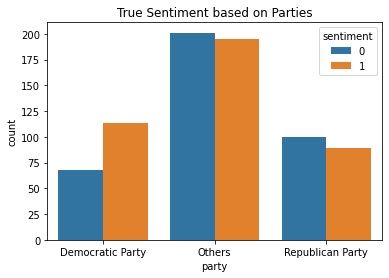

In [82]:
sns.countplot('party', hue='sentiment', data=yus_test_SN)
plt.title('True Sentiment based on Parties')

Text(0.5, 1.0, 'Predicted Sentiment based on Parties')

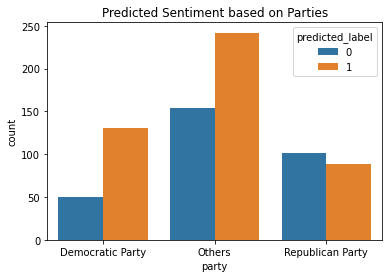

In [83]:
sns.countplot('party', hue='predicted_label', data=yus_test_SN)
plt.title('Predicted Sentiment based on Parties')

From both visualizations, the differences between prediction and true sentiment concentrated on Others Paty and Democratic Party. The positve predictions increased in both Others Party and Democratic Party. The reason here might be the information from Others Party is relatively more and that from Democratic Party is relatively less. Even through the model trained from US Election Data, it is not accurate enough to predict sentiment of different parties through the content of tweets. There are a few ways to improve the process:
1. I need to try more samples from the sentiment analysis data. 
2. I could try more accurate way to distinguish the party to which tweet belongs.
3. I could adjust the number of features when vertorization and use them to train models.

## Negative Reason Analysis

In [84]:
Xus_train_neg = Xus_train[Xus_train.sentiment == 0]
Xus_test_neg = Xus_test[Xus_test.sentiment == 0]

Xus_train_bow = Xus_train_neg['bow'].apply(pd.Series)
Xus_test_bow = Xus_test_neg['bow'].apply(pd.Series)

Xus_train_tfidf = Xus_train_neg['tfidf'].apply(pd.Series)
Xus_test_tfidf = Xus_test_neg['tfidf'].apply(pd.Series)

yus_train_neg = yus_train_SN[yus_train_SN.sentiment == 0]
yus_test_neg = yus_test_SN[yus_test_SN.sentiment == 0]

yus_train = yus_train_neg['negative_reason']
yus_test = yus_test_neg['negative_reason']

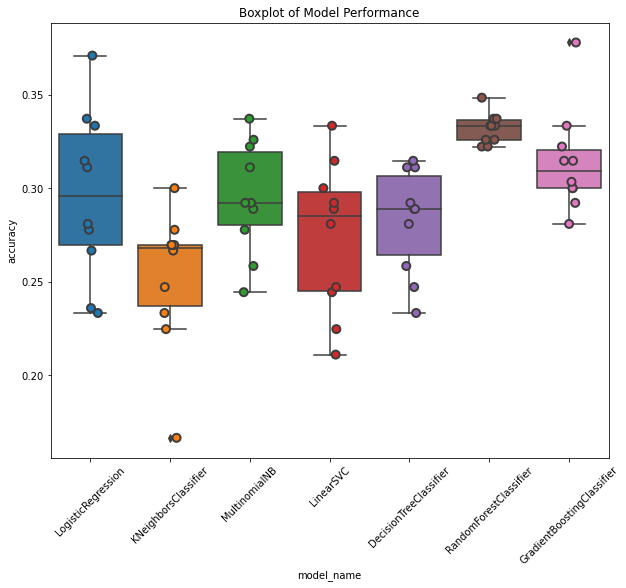

In [85]:
models = [
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3),
    MultinomialNB(),
    LinearSVC(),
    DecisionTreeClassifier(criterion='entropy'),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    GradientBoostingClassifier(n_estimators=100, random_state=0)
]
CV = 10
cv_models = pd.DataFrame(index=range(CV * len(models)))
entries = []

features = Xus_train_bow
labels = yus_train

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_models = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


plt.figure(figsize=(10, 8))
sns.boxplot(x='model_name', y='accuracy', data=cv_models)
sns.stripplot(x='model_name', y='accuracy', data=cv_models, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.title('Boxplot of Model Performance')
plt.show()

In [86]:
cv_models.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier        0.282659
GradientBoostingClassifier    0.313895
KNeighborsClassifier          0.252534
LinearSVC                     0.273733
LogisticRegression            0.296155
MultinomialNB                 0.295006
RandomForestClassifier        0.331860
Name: accuracy, dtype: float64

In general, the models using bag of words feature have relatively low accuracies and the best one is Random Forrest Classifier which has 33.2% accuracy.

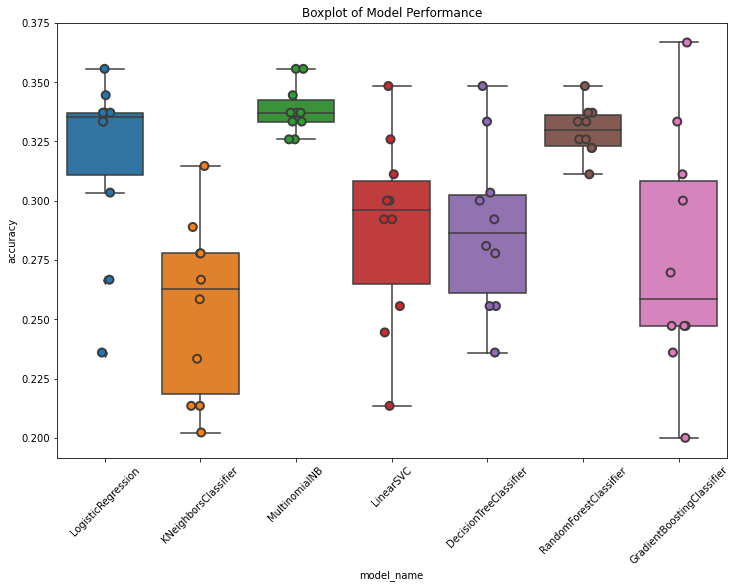

In [87]:
models = [
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3),
    MultinomialNB(),
    LinearSVC(),
    DecisionTreeClassifier(criterion='entropy'),
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    GradientBoostingClassifier(n_estimators=100, random_state=0)
]
CV = 10
cv_tfidf = pd.DataFrame(index=range(CV * len(models)))
entries = []

features = Xus_train_tfidf
labels = yus_train

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_tfidf = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=(12, 8))
sns.boxplot(x='model_name', y='accuracy', data=cv_tfidf)
sns.stripplot(x='model_name', y='accuracy', data=cv_tfidf, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.title('Boxplot of Model Performance')
plt.show()

In [88]:
cv_tfidf.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier        0.288290
GradientBoostingClassifier    0.275830
KNeighborsClassifier          0.254669
LinearSVC                     0.288302
LogisticRegression            0.318390
MultinomialNB                 0.338514
RandomForestClassifier        0.329638
Name: accuracy, dtype: float64

From the above accuracies, the models using TFIDF features perform better than that using bag of words features. However, the overall accuracies are relatively low and the best one is MultinomialNB that has 33.8% accuracy. 

Text(0.5, 1.0, 'Negative Reasons Distribution for US Election')

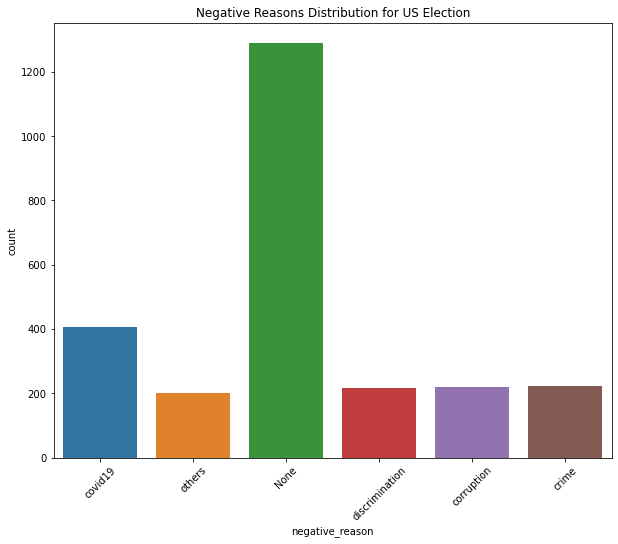

In [89]:
plt.figure(figsize=(10, 8))
sns.countplot(x = 'negative_reason', data = US_Elections)
plt.xticks(rotation=45)
plt.title('Negative Reasons Distribution for US Election')

From my perspective, the main reason that might fail to predict the correct negative reason is "None" type accounts for the largest proportion of data, which might have influence on training models. The way that might improve the outcome is remove the 'None' category to retrain the data. But the remaining data would become less through this way. In addition, adjusting the max features when vectorized the text might also improve the result. 